In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import dill
dill.settings['recurse'] = True

from tqdm import tqdm
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data
from random import choice, sample, shuffle

In [22]:
F = dill.load(open("final", "rb"))

In [23]:
t = np.linspace(0, 2*np.pi, 40, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [24]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="Rpq30a0.01ne")

In [26]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(10, 10))
# ax = plt.subplot(222, aspect='equal')
# tplot(ax, **cndt)
# plt.show()

In [27]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [28]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)
boundary_normal = np.zeros((points.shape[0], 2))
is_set = np.zeros(points.shape[0], dtype=np.bool_)
boundary_triangle = np.zeros_like(is_set, dtype=int)-1

In [29]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        is_boundary_point[element] = True
        
    elif (neighbours[index] == -1).sum() == 1:
        
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True
        
        origin_point_idx = element[indices_[0]] if is_boundary_point[element[(indices_[0] + 1) % 3]] == True else element[indices_[1]]
        end_point_idx = element[indices_[0]] if origin_point_idx == element[indices_[1]] else element[indices_[1]]
        
        
        fp = points[origin_point_idx]
        sp = points[end_point_idx]
        
        
        boundary_normal[origin_point_idx][0] =  -(fp[1] - sp[1])
        boundary_normal[origin_point_idx][1] =  (fp[0] - sp[0])
        
        boundary_triangle[origin_point_idx] = index
        
        is_set[origin_point_idx] = True

        
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        set_ = np.where(is_set[element] == True)[0][0]
        
        start_1 = (set_ + 1) % 3
        end_1 = (start_1 + 1) % 3
        
        start_2 = end_1
        end_2 = set_
        
        boundary_normal[element[start_1]][0] =  (points[element[end_1]][1] - points[element[start_1]][1])
        boundary_normal[element[start_1]][1] =  -(points[element[end_1]][0] - points[element[start_1]][0])     
                
        boundary_normal[element[start_2]][0] =  (points[element[end_2]][1] - points[element[start_2]][1])
        boundary_normal[element[start_2]][1] =  -(points[element[end_2]][0] - points[element[start_2]][0])             
        
        boundary_triangle[element[start_1]] = index
        boundary_triangle[element[start_2]] = index        

boundary_normal[is_boundary_point] = boundary_normal[is_boundary_point] / (boundary_normal[is_boundary_point]**2).sum(axis=-1, keepdims=True) ** 0.5

In [30]:
all_colors = list(mcolors.BASE_COLORS.keys()) + list(mcolors.CSS4_COLORS.keys()) + list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())

In [31]:
# shuffle(all_colors)
# colors = all_colors
# l = len(colors)

# %matplotlib inline
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.axis("equal")


# for index, triangle in enumerate(triangles_s):
#     t1 = plt.Polygon(triangle, color=colors[index%l])
#     fig.gca().add_patch(t1)
    
#     x, y = triangle.mean(axis=0)
# #     ax.text(x, y, s=f"{index}", fontsize=10)

# for idx, point in enumerate(points):
#     pass
#     ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=10, color="black")
    
# for idx, point in enumerate(points):
#     if is_boundary_point[idx]:
#         ax.scatter(point[0], point[1], color="black", lw=10, s=2)
#         ax.quiver(point[0], point[1], boundary_normal[idx,0], boundary_normal[idx,1], color=['r','b','g'], scale=21)
#     else:
#         ax.scatter(point[0], point[1], color="black")
        
# fig.tight_layout()
# plt.show()

In [32]:
matrix = np.zeros((6 * points.shape[0], 6 * points.shape[0]), dtype=np.float32)
b = np.zeros(6 * points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
        
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    S2 = (x2-x1)*(y3-y1)-(x3-x1)*(y2-y1)
    
    P_1_x = (+y2 - y3) / S2
    P_2_x = (-y1 + y3) / S2
    
    P_1_y = (-x2 + x3) / S2
    P_2_y = (+x1 - x3) / S2
    
    
    arg = [P_1_x, 
           P_2_x, 
           P_1_y, 
           P_2_y]
    
    delta = (x1 - x3) * (y2 - y3) - (y1 - y3) * (x2 - x3)

    
    # p_1
    if is_boundary_point[element[0]] == True:
        
        if idx == boundary_triangle[element[0]]:
            
            matrix[6 * element[0]+0, 6 * element[0]+0] = 1
            matrix[6 * element[0]+1, 6 * element[0]+1] = 1
            matrix[6 * element[0]+2, 6 * element[0]+2] = 1
            matrix[6 * element[0]+3, 6 * element[0]+3] = 1
            matrix[6 * element[0]+4, 6 * element[0]+4] = 1
            matrix[6 * element[0]+5, 6 * element[0]+5] = 1
            
            

            b[6 * element[0]+0] = 0
            b[6 * element[0]+1] = 0
            b[6 * element[0]+2] = 0 
            b[6 * element[0]+3] = 0 
            b[6 * element[0]+4] = 0 
            b[6 * element[0]+5] = 0 

    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[0]+i, 6*element[j]+k] += 2 * F[f"{3*i}_{3*k+j}"](*arg) * delta
    
        b[6 * element[0]+0] += 2 * F["0"]  * delta
        b[6 * element[0]+1] += 2 * F["3"]  * delta
        b[6 * element[0]+2] += 2 * F["6"]  * delta
        b[6 * element[0]+3] += 2 * F["9"]  * delta
        b[6 * element[0]+4] += 2 * F["12"] * delta
        b[6 * element[0]+5] += 2 * F["15"] * delta
        
    if is_boundary_point[element[1]] == True:
    
        if idx == boundary_triangle[element[1]]:

            matrix[6 * element[1]+0, 6 * element[1]+0] = 1
            matrix[6 * element[1]+1, 6 * element[1]+1] = 1
            matrix[6 * element[1]+2, 6 * element[1]+2] = 1
            matrix[6 * element[1]+3, 6 * element[1]+3] = 1
            matrix[6 * element[1]+4, 6 * element[1]+4] = 1
            matrix[6 * element[1]+5, 6 * element[1]+5] = 1
        

            b[6 * element[1]+0] = 0
            b[6 * element[1]+1] = 0        
            b[6 * element[1]+2] = 0
            b[6 * element[1]+3] = 0
            b[6 * element[1]+4] = 0
            b[6 * element[1]+5] = 0

    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[1]+i, 6*element[j]+k] += 2 * F[f"{3*i+1}_{3*k+j}"](*arg) * delta
    
        b[6 * element[1]+0] += 2 * F["1"]  * delta
        b[6 * element[1]+1] += 2 * F["4"]  * delta
        b[6 * element[1]+2] += 2 * F["7"]  * delta
        b[6 * element[1]+3] += 2 * F["10"] * delta
        b[6 * element[1]+4] += 2 * F["13"] * delta
        b[6 * element[1]+5] += 2 * F["16"] * delta
        
    if is_boundary_point[element[2]] == True:        
        
        if idx == boundary_triangle[element[2]]:
            
            matrix[6 * element[2]+0, 6 * element[2]+0] = 1
            matrix[6 * element[2]+1, 6 * element[2]+1] = 1
            matrix[6 * element[2]+2, 6 * element[2]+2] = 1
            matrix[6 * element[2]+3, 6 * element[2]+3] = 1
            matrix[6 * element[2]+4, 6 * element[2]+4] = 1
            matrix[6 * element[2]+5, 6 * element[2]+5] = 1
            
        
            b[6 * element[2]+0] = 0
            b[6 * element[2]+1] = 0       
            b[6 * element[2]+2] = 0 
            b[6 * element[2]+3] = 0 
            b[6 * element[2]+4] = 0 
            b[6 * element[2]+5] = 0 
        
    else:
        
        for i in range(6):
            for j in range(3):
                for k in range(6):
                    matrix[6*element[2]+i, 6*element[j]+k] += 2 * F[f"{3*i+2}_{3*k+j}"](*arg) * delta
    
        b[6 * element[2]+0] += 2 * F["2"] * delta
        b[6 * element[2]+1] += 2 * F["5"]  * delta
        b[6 * element[2]+2] += 2 * F["8"]  * delta
        b[6 * element[2]+3] += 2 * F["11"] * delta
        b[6 * element[2]+4] += 2 * F["14"] * delta
        b[6 * element[2]+5] += 2 * F["17"] * delta

100%|████████████████████████████████████████| 491/491 [00:04<00:00, 100.03it/s]


In [33]:
c = np.linalg.solve(matrix, b)

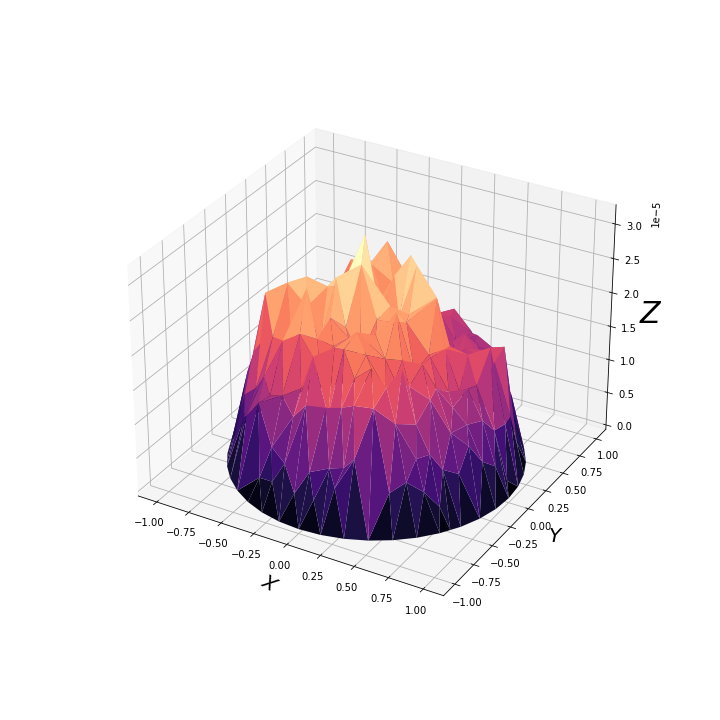

In [34]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_xlabel('$X$', fontsize=20, rotation=150)
ax.set_ylabel('$Y$', fontsize=20, rotation=0)
ax.set_zlabel('$Z$', fontsize=30, rotation=0)

# ax.set_box_aspect((np.ptp(points[:, ]), np.ptp(points[:, 1]), 2 * np.ptp(FFF)))

ax.plot_trisurf(points[:, 0], points[:, 1], c[0::6], cmap="magma")


plt.show()

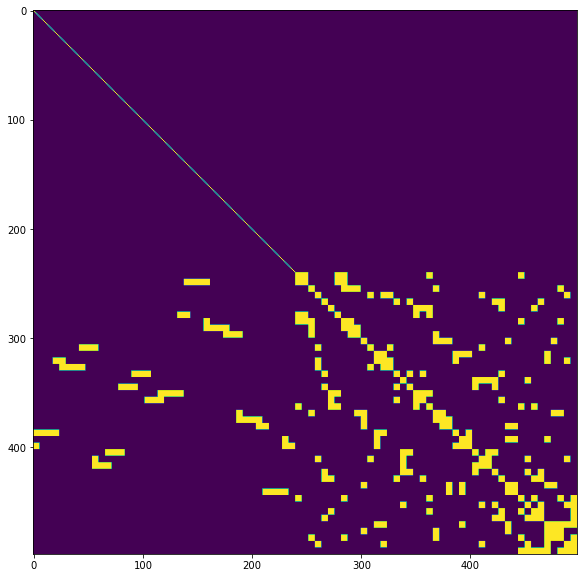

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(matrix != 0)
plt.show()